## <center> Практическое задание к лекции 7

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Исходный [датасет](https://www.kaggle.com/fedesoriano/heart-failure-prediction)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Описание датасета:  
1. Age: возраст пациента [лет]
2. Sex: пол пациента [M: мужской, F: женский]  
3. ChestPainType: тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинальная боль, ASY: бессимптомно]  
4. RestingBP: артериальное давление в состоянии покоя [мм рт.]  
5. Cholesterol: холестерин сыворотки [мм / дл]  
6. FastingBS: уровень сахара в крови натощак [1: если натощак> 120 мг / дл, 0: в противном случае]  
7. RestingECG: результаты электрокардиограммы в покое [Normal: Нормальный, ST: наличие отклонения, ST-T (инверсия зубца T и / или подъем или депрессия ST> 0,05 мВ), LVH: показывает вероятную или определенную гипертрофию левого желудочка по критериям Эстеса]  
8. MaxHR: достигнутая максимальная частота пульса [Числовое значение от 60 до 202]  
9. ExerciseAngina: стенокардия, вызванная физической нагрузкой [Y: Да, N: Нет]  
10. Oldpeak: oldpeak = ST [Числовое значение в депрессии]  
11. ST_Slope: наклон сегмента ST при пиковом упражнении [Вверх: восходящий, плоский: ровный, Вниз: нисходящий]  
12. HeartDisease: выходной класс [1: болезнь сердца, 0: нормальный]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Набор данных содержит 12 столбцов, включая 11 признаков и 1 целевую переменную
5 признаков представляют собой переменную типа str, 1 float64 и 6 int64

In [4]:
#числовые признаки
num_cols=df.select_dtypes(include=np.number).columns.tolist()
# категориальные признаки
cat_cols=df.select_dtypes(object).columns.tolist()
print(f'Числовых признаков {len(num_cols)}, а именно:\n{num_cols}\n'
     f'\nКатегориальных признаков {len(cat_cols)}, а именно:\n{cat_cols}')


Числовых признаков 7, а именно:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Категориальных признаков 5, а именно:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


Пропуски в данных:

In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Пропусков нет

### EDA

### Категориальные признаки

In [6]:
print(f'{len(cat_cols)} категориальных признаков\n{cat_cols}\n')
# Extract details on categorical features
for i in cat_cols:
    unique_no = df[i].nunique()
    unique_name = df[i].unique().tolist()
    print(f'{i}, имеет {unique_no} уникальнх значения:\n{unique_name}\n')
    

5 категориальных признаков
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Sex, имеет 2 уникальнх значения:
['M', 'F']

ChestPainType, имеет 4 уникальнх значения:
['ATA', 'NAP', 'ASY', 'TA']

RestingECG, имеет 3 уникальнх значения:
['Normal', 'ST', 'LVH']

ExerciseAngina, имеет 2 уникальнх значения:
['N', 'Y']

ST_Slope, имеет 3 уникальнх значения:
['Up', 'Flat', 'Down']



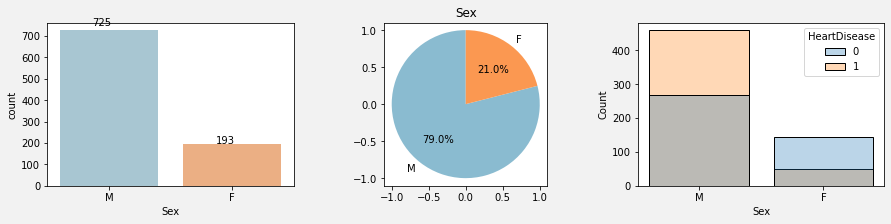

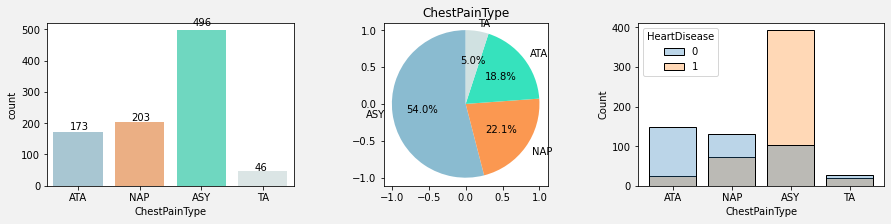

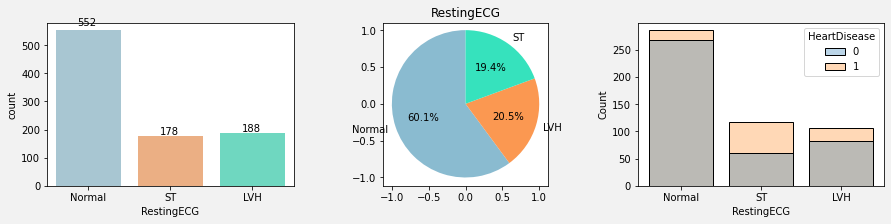

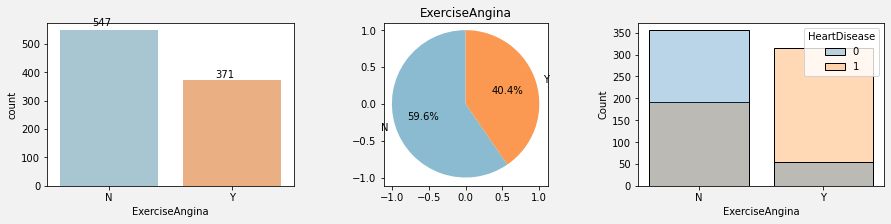

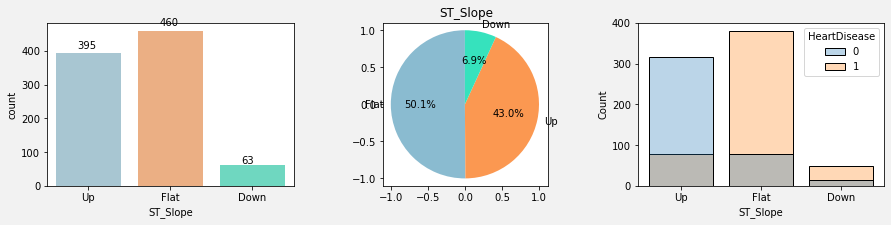

In [7]:
# Summary of categorical data
palette = ['#8abbd0', '#FB9851', '#36E2BD','#D0E1E1']

for feature in cat_cols:
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    fig.patch.set_facecolor('#F2F2F2')

    sns.countplot(x=df[feature], data=df, ax=ax[0], palette=palette, alpha=0.8)
    for p, label in zip(ax[0].patches, df[feature].value_counts().index):
        ax[0].annotate(p.get_height(), (p.get_x()+p.get_width()/3, p.get_height()*1.03))
                    
    df[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=ax[1], colors=palette, frame=True)
    ax[1].set_ylabel('')
    ax[1].set_title(feature)

    sns.histplot(x=feature,data=df, hue='HeartDisease',ax=ax[2], alpha=0.3, shrink=.8)  
    
plt.tight_layout
plt.show()

### Числовые признаки

In [8]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


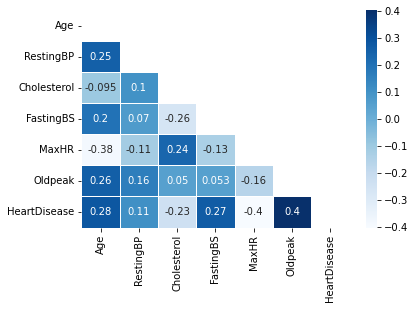

In [9]:
fig = plt.figure(figsize=(6,4)) 
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap='Blues', annot=True, mask=mask, linewidth=0.5)
plt.show()

Корреляция между признаками невысокая

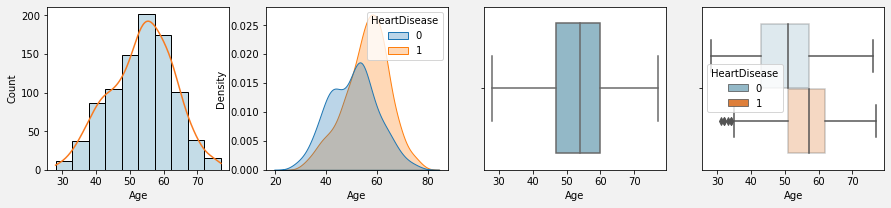

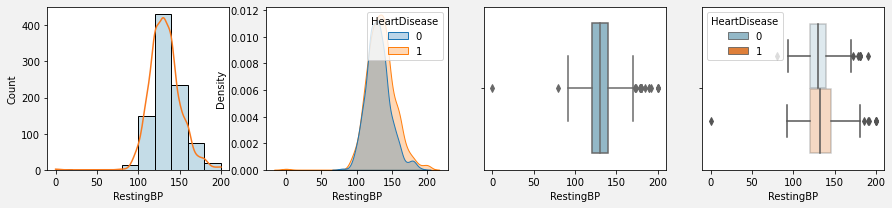

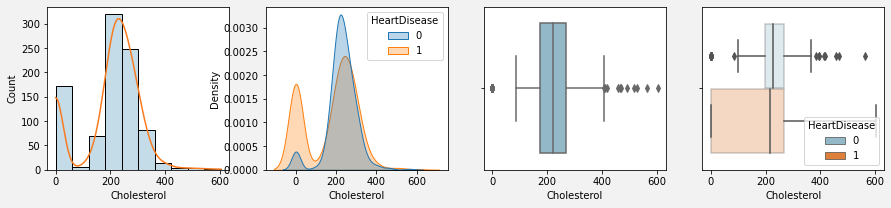

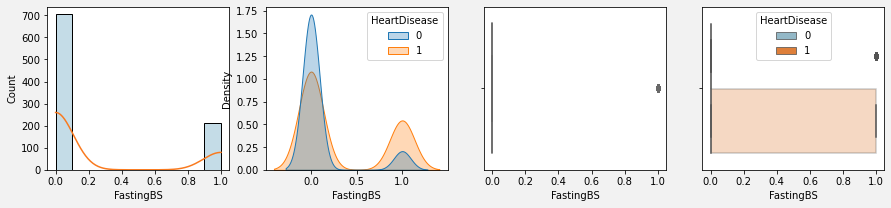

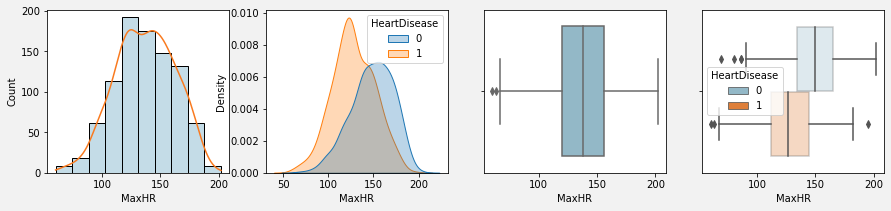

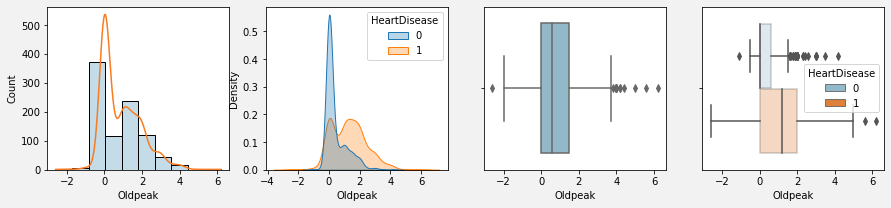

In [10]:
# Plots on numerical features to check data quality and data distribution
color ='#8abbd0'

for i in num_cols[:-1]:
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    fig.patch.set_facecolor( '#F2F2F2')
    sns.histplot(df[i], bins=10, ax=ax[0],  color=color, kde=True)
    ax[0].lines[0].set_color('#F97A1F')
    sns.kdeplot(x=i,data=df, hue='HeartDisease',ax=ax[1],shade=True, alpha=0.3)
    sns.boxplot(x=i, data=df,ax=ax[2], color=color)
    sns.boxplot(x=i, data=df, hue='HeartDisease',y=[""]*len(df),ax=ax[3],palette=['#8abbd0','#F97A1F'],boxprops=dict(alpha=.3))
    plt.tight_layout
plt.show()

Обратим внимание, что:

RestingBP имеет экстремальные выбросы  
Cholesterol имеет много нулевых значений

## Feature engineering

Глядя на диаграмму выше, мы замечаем, что RestingBP имеет экстремальный выброс при 0. Вероятно, это неверное значение, мы удалим его из набора данных.  
  
Cholesterol имеет несколько нулевых значений, мы заменим их медианой  

Функции масштабирования:  
В разделе EDA мы видим, что существует значительная разница в порядке величины между числовыми характеристиками. Поэтому будем использовать StandardScaler для настройки размеров объектов  
Преобразование категориальных значений в числовые значения:  
Будем использовать LabelEncoder для преобразования данных

Удалим выбросы по RestingBP 

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

In [12]:
row = df[df['RestingBP']==0].index
df = df.drop(df.index[row])

Используем LabelEncoder

In [13]:
le = LabelEncoder()
#heart[cat_cols] = heart[cat_cols].astype('str').apply(le.fit_transform)
df[cat_cols] = df[cat_cols].apply(le.fit_transform)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    int32  
 2   ChestPainType   917 non-null    int32  
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    int32  
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    int32  
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    int32  
 11  HeartDisease    917 non-null    int64  
dtypes: float64(1), int32(5), int64(6)
memory usage: 75.2 KB


In [15]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        self.median_values=X['Cholesterol'].median()
        return self

    def transform(self, X):
        if self.key=='Cholesterol':
            row = X[X['Cholesterol']==0].index
            X.loc[row, 'Cholesterol'] = self.median_values
            
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [16]:
continuos_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
base_cols=[*cat_cols+['FastingBS']]

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
'''for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))'''
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))


In [17]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.05686975, -0.15707826,  0.24249731, ...,  0.        ,
         2.        ,  0.        ],
       [ 0.68702327,  0.394623  ,  0.75498668, ...,  1.        ,
         1.        ,  0.        ],
       [-0.57328377,  0.94632426, -0.23338568, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.84230472, -1.15014053, -1.66103465, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.05686975,  0.00843212, -0.67266228, ...,  0.        ,
         2.        ,  0.        ],
       [ 0.79204885, -0.70877952,  0.37061965, ...,  1.        ,
         1.        ,  0.        ]])

In [19]:
cls=Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [20]:
cls.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('RestingBP',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='RestingBP')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('Cholesterol',
                                                 Pipeline(steps=[('selector',
                             

In [21]:
y_predict = cls.predict(X_test)

In [22]:
results = {
    'approach': [],
    'f1': [],
    'roc': [],
    'recall':[],
    'precision':[]
}

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 



results['approach'].append('rfc')
results['f1'].append(f1_score(y_test, y_predict))
results['roc'].append(roc_auc_score(y_test, y_predict))
results['recall'].append(recall_score(y_test, y_predict, average='binary'))
results['precision'].append(precision_score(y_test, y_predict, average='binary'))

evaluate_results(y_test, y_predict)

Classification results:
f1: 86.99%
roc: 84.05%
recall: 89.31%
precision: 84.78%


Посмотрим на важность признаков

In [23]:
cls[1].feature_importances_

array([0.08321201, 0.07536684, 0.08145463, 0.11160486, 0.10607988,
       0.03210463, 0.11724558, 0.02841589, 0.0933306 , 0.24603253,
       0.02515255])

In [24]:
features = pd.DataFrame(cls[1].feature_importances_, 
                        X_train.columns, 
                        columns=['coefficient']).sort_values(by=['coefficient'], ascending=False)

In [25]:
features

,coefficient
Oldpeak,0.246033
RestingECG,0.117246
RestingBP,0.111605
Cholesterol,0.106080
ExerciseAngina,0.093331
Age,0.083212
ChestPainType,0.081455
Sex,0.075367
FastingBS,0.032105
MaxHR,0.028416


In [26]:
#!pip install shap

In [27]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [28]:
explainer = shap.TreeExplainer(cls[1])
shap_values = explainer.shap_values(X_train)

In [29]:
shap_values1=shap_values[0]

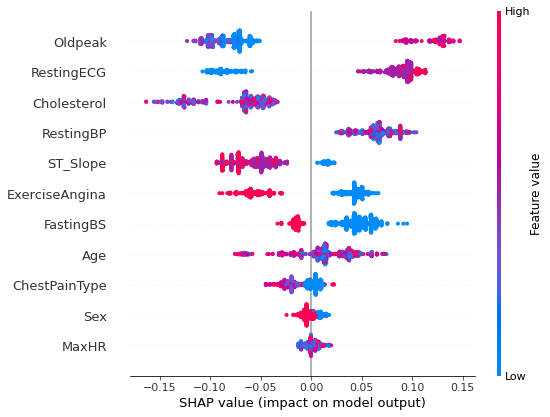

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values1, X_train)

In [31]:
shap.force_plot(explainer.expected_value[0], shap_values[0][25],  X_train.iloc[25,:])